In [135]:
from __future__ import annotations

import trieste
import tensorflow as tf
import numpy as np
from trieste.acquisition.interface import (
    AcquisitionFunction,
    SingleModelAcquisitionBuilder,
)
from typing import Optional, cast, Generic, TypeVar, Sequence
from trieste.data import Dataset
from trieste.types import TensorType
import tensorflow_probability as tfp
from trieste.acquisition import AcquisitionFunctionClass
from trieste.objectives import scaled_branin
from trieste.models.gpflow.builders import build_gpr
from trieste.models.gpflow import GaussianProcessRegression
from trieste.models.interfaces import (
    ProbabilisticModel,
    TrainableProbabilisticModel,
)
from gpflow.logdensities import multivariate_normal
import gpflow
from gpflow.models import GPR
import math
import matplotlib.pyplot as plt
OBJECTIVE = "OBJECTIVE"

ProbabilisticModelType = TypeVar(
    "ProbabilisticModelType", bound="ProbabilisticModel", contravariant=True
)
import concurrent.futures
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# 2-fidelity model wrapper

In [136]:


class MultiFidelityModel(TrainableProbabilisticModel):
    """
    This is a wrapper for a two fidelity model following (https://hal.inria.fr/hal-02901774/document)
    """
    def __init__(
        self,
        low_fidelity_model: GaussianProcessRegression,
        residual_model: GaussianProcessRegression,
    ):
        r"""
        TODO
        The order of individual models specified at :meth:`__init__` determines the order of the
        :class:`MultiFidelityModel` fidelities.

        :param low_fidelity_model: The GP model of the lowest fidelity
        :param residual_model: The GP model of the residual
        """
        self._low_fidelity_model = low_fidelity_model
        self._residual_model = residual_model 
        self._rho = gpflow.Parameter(1.0, trainable=True) # set this as a Parameter so that we can optimize i 
    
        
    def predict(self, query_points: TensorType) -> tuple[TensorType, TensorType]:
        r"""
        :param query_points: The points at which to make predictions, of shape [..., D+1]. The last
            dimension is the fidelity level.
        :return: The predictions from the model with fidelity corresponding to the last dimension of
            query_points.
        """
        input_points = query_points[..., :-1]
        fidelities = query_points[..., -1:]  # [..., 1]
        lowfi_mask = (fidelities == 0.)

        mean_lowfi, var_lowfi = self._low_fidelity_model.predict(input_points)
        mean_residual, var_residual = self._residual_model.predict(input_points)

        mean = tf.where(lowfi_mask, mean_lowfi, mean_residual + self._rho*mean_lowfi)
        var = tf.where(lowfi_mask, var_lowfi, var_residual + (self._rho**2)*var_lowfi)
        
        return mean, var
    def get_observation_noise(self)   -> float : 
        return float(self._residual_model.model.likelihood.variance.numpy())    
#         raise NotImplementedError("not yet coded up functionality for predict_y")
    def sample(self, query_points: TensorType, num_samples: int) -> TensorType:
        raise NotImplementedError("not yet coded up functionality for sampling")

    def predict_y(self, query_points: TensorType) -> tuple[TensorType, TensorType]:
        raise NotImplementedError("not yet coded up functionality for predict_y")
      
    def update(self, dataset: Dataset) -> None:
        """
        Update the two models on their corresponding data. The data for each model is
        extracted by splitting the observations in ``dataset`` by fidelity level.

        :param dataset: The query points and observations for *all* the wrapped models.
        """
        lowfi_points, highfi_points, lowfi_mask, highfi_mask, ind_lowfi, ind_highfi = filter_by_fidelity(dataset.query_points)
        self._low_fidelity_model.update(Dataset(lowfi_points, tf.gather(dataset.observations, ind_lowfi)))
        residuals = tf.gather(dataset.observations, ind_highfi) - self._rho * self._low_fidelity_model.predict_y(highfi_points)[0]
        self._residual_model.update(Dataset(highfi_points, residuals))

    def optimize(self, dataset: Dataset) -> None:
        """
        Optimize all the models on their corresponding data. The data for each model is
        extracted by splitting the observations in ``dataset``  by fidelity level.
        
        Note that we have to code up a custom loss function when optimizing our residual model, so that we
        can include the correlation parameter as an optimisation variable.

        :param dataset: The query points and observations for *all* the wrapped models.
        """
       
        lowfi_points, highfi_points, lowfi_mask, highfi_mask, ind_lowfi, ind_highfi = filter_by_fidelity(dataset.query_points)
        self._low_fidelity_model.optimize(Dataset(lowfi_points, tf.gather(dataset.observations, ind_lowfi)))
        gpflow_residual_model = self._residual_model.model
        gpflow_low_fidelity_model=self._low_fidelity_model.model
        high_fidelity_observations = tf.gather(dataset.observations, ind_highfi)
        predictions_from_low_fidelity = self._low_fidelity_model.predict(highfi_points)[0]
        
        def loss(): # hardcoded log liklihood calculation for the residual model
            residuals = high_fidelity_observations - self._rho * predictions_from_low_fidelity
            K = gpflow_residual_model.kernel(highfi_points)
            ks = gpflow_residual_model._add_noise_cov(K)
            L = tf.linalg.cholesky(ks)
            m = gpflow_residual_model.mean_function(highfi_points)
            log_prob = multivariate_normal(residuals, m, L)
            return -1.0 * tf.reduce_sum(log_prob)
        
        trainable_variables = gpflow_residual_model.trainable_variables + self._rho.variables
        self._residual_model.optimizer.optimizer.minimize(loss, trainable_variables)
        self._residual_model.update(Dataset(highfi_points, high_fidelity_observations - self._rho * predictions_from_low_fidelity))
        
        
        self._inv_lowfi_correlation_matrix=tf.linalg.inv( gpflow_low_fidelity_model._add_noise_cov(gpflow_low_fidelity_model.kernel(lowfi_points)  ))
        self._inv_highfi_correlation_matrix=tf.linalg.inv( gpflow_residual_model._add_noise_cov(gpflow_residual_model.kernel(highfi_points)  ))
        self._low_fidelity_points=lowfi_points
        self._high_fidelity_points=highfi_points
        

        
        
def filter_by_fidelity(query_points: TensorType):

    input_points = query_points[:, :-1]  # [..., D+1]
    fidelities = query_points[:, -1:]  # [..., 1]
    lowfi_mask = (fidelities[:, 0] == 0.)
    ind_lowfi = tf.where(lowfi_mask)[:, 0]
    highfi_mask = (fidelities[:, 0] == 1.)
    ind_highfi = tf.where(highfi_mask)[:, 0]
    lowfi_points = tf.gather(input_points, ind_lowfi, axis=0)
    highfi_points = tf.gather(input_points, ind_highfi, axis=0)
    return lowfi_points, highfi_points, lowfi_mask, highfi_mask, ind_lowfi, ind_highfi


Text(0.5, 1.0, 'chosen rho as 2.009712504411695')

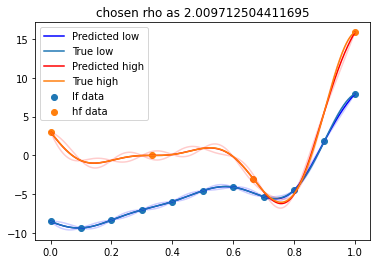

In [137]:
# Replace this with your own observer
def my_simulator(x_input, fidelity):
    # this is a dummy objective
    f = 0.5 * ((6.0*x_input-2.0)**2)*tf.math.sin(12.0*x_input - 4.0) + 10.0*(x_input -1.0)
    return f + fidelity * (f - 20.0*(x_input -1.0))


def observer(x):
    # last dimension is the fidelity value
    x_input = x[..., :-1]
    x_fidelity = x[...,-1:]

    # note: this assumes that my_simulator broadcasts, i.e. accept matrix inputs.
    # If not you need to replace this by a for loop over all rows of "input"
    observations = my_simulator(x_input, x_fidelity)
    return trieste.data.Dataset(x, observations)


num_init = 12
input_dim = 1
lb = np.zeros(input_dim)
ub = np.ones(input_dim)

input_search_space = trieste.space.Box(lb, ub)
fidelity_search_space = trieste.space.DiscreteSearchSpace(np.array([0., 1.]).reshape(-1, 1))
search_space = trieste.space.TaggedProductSearchSpace([input_search_space, fidelity_search_space],
                                                      ["input", "fidelity"])

X = tf.linspace(0,1,11)[:, None]
initial_sample_low = tf.concat([X,tf.zeros_like(X)],1)
X = tf.linspace(0,1,4)[:, None]
initial_sample_high = tf.concat([X,tf.ones_like(X)],1)
initial_sample = tf.concat([initial_sample_low,initial_sample_high],0)
initial_data = observer(initial_sample)

lowfi_points, highfi_points, lowfi_mask, highfi_mask, ind_lowfi, ind_highfi = filter_by_fidelity(initial_data.query_points)
lf_data = Dataset(lowfi_points, tf.gather(initial_data.observations, ind_lowfi))
hf_data = Dataset(highfi_points, tf.gather(initial_data.observations, ind_highfi))

low_fidelity_gpr = GaussianProcessRegression(build_gpr(lf_data, input_search_space,  likelihood_variance = 1e-5, kernel_priors=False))
high_fidelity_gpr = GaussianProcessRegression(build_gpr(hf_data, input_search_space, likelihood_variance = 1e-5, kernel_priors=False)) # ignore this


model = MultiFidelityModel(
    low_fidelity_model = low_fidelity_gpr,
    residual_model = high_fidelity_gpr,
)
model.update(initial_data)
model.optimize(initial_data)


X = tf.linspace(0,1,1000)[:, None]
X_low = tf.concat([X,tf.zeros_like(X)],1)
X_high = tf.concat([X,tf.ones_like(X)],1)
mean, var = model.predict(X_low)
plt.plot(X,mean, label="Predicted low", color="blue")
plt.plot(X,mean+1.96*tf.math.sqrt(var),color="blue",alpha=0.2)
plt.plot(X,mean-1.96*tf.math.sqrt(var), color="blue", alpha=0.2)
plt.plot(X,observer(X_low).observations, label="True low")
mean, var = model.predict(X_high)
plt.plot(X,mean, label="Predicted high", color="red")
plt.plot(X,mean+1.96*tf.math.sqrt(var),color="red",alpha=0.2)
plt.plot(X,mean-1.96*tf.math.sqrt(var), color="red", alpha=0.2)
plt.plot(X,observer(X_high).observations, label="True high")
plt.scatter(lowfi_points, tf.gather(initial_data.observations, ind_lowfi), label="lf data")
plt.scatter(highfi_points, tf.gather(initial_data.observations, ind_highfi), label="hf data")
plt.legend()
plt.title(f"chosen rho as {model._rho.numpy()}")


# Dummy BO loop (you need to code your own acq here)

In [138]:
##  The following acqusition function is NOT CORRECT
## It is just a dummy code to demonstrate what you need to do. We just have implemented a weighting depending on the
# fidelity level we query. 
class MultiFidelityExpectedImprovement(SingleModelAcquisitionBuilder[ProbabilisticModel]):

    def __repr__(self) -> str:
        return "MultiFidelityExpectedImprovement()"

    def prepare_acquisition_function(
            self,
            model: ProbabilisticModel,
            dataset: Optional[Dataset] = None,
    ) -> AcquisitionFunction:
        tf.debugging.Assert(dataset is not None, [])
        dataset = cast(Dataset, dataset)
        tf.debugging.assert_positive(len(dataset), message="Dataset must be populated.")

        altered_fidelity_points= tf.concat([dataset.query_points[:,:-1],tf.ones_like(dataset.query_points[:,:-1])],1)[:,:-1]

        # This line assumes that model.predict returns the prediction for x = [input, fidelity]
        mean, _ = model.predict(altered_fidelity_points)
        eta = tf.reduce_min(mean, axis=0) ## this is f_hat( x_best)
        return multifidelity_expected_improvement(model, eta)

    def update_acquisition_function(
            self,
            function: AcquisitionFunction,
            model: ProbabilisticModel,
            dataset: Optional[Dataset] = None,
    ) -> AcquisitionFunction:
        tf.debugging.Assert(dataset is not None, [])
        dataset = cast(Dataset, dataset)
        tf.debugging.assert_positive(len(dataset), message="Dataset must be populated.")
        tf.debugging.Assert(isinstance(function, multifidelity_expected_improvement), [])

        ltered_fidelity_points= tf.concat([dataset.query_points[:,:-1],tf.ones_like(dataset.query_points[:,:-1])],1)[:,:-1]
        mean, _ = model.predict(altered_fidelity_points)
        eta = tf.reduce_min(mean, axis=0)
        function.update(eta)  # type: ignore
        return function




In [157]:
##  The following acqusition function is NOT CORRECT
## It is just a dummy code to demonstrate what you need to do. We just have implemented a weighting depending on the
# fidelity level we query. 
import multiprocessing as mp
class MultiFidelityExpectedImprovement(SingleModelAcquisitionBuilder[ProbabilisticModel]):

    def __repr__(self) -> str:
        return "MultiFidelityExpectedImprovement()"

    def prepare_acquisition_function(
            self,
            model: ProbabilisticModel,
            dataset: Optional[Dataset] = None,
    ) -> AcquisitionFunction:
        tf.debugging.Assert(dataset is not None, [])
        dataset = cast(Dataset, dataset)
        tf.debugging.assert_positive(len(dataset), message="Dataset must be populated.")

        altered_fidelity_points= tf.concat([dataset.query_points[:,:-1],tf.ones_like(dataset.query_points[:,:-1])],1)[:,:-1]

        # This line assumes that model.predict returns the prediction for x = [input, fidelity]
        mean, _ = model.predict(altered_fidelity_points)
        eta = tf.reduce_min(mean, axis=0) ## this is f_hat( x_best)
        return multifidelity_expected_improvement(model, eta)

    def update_acquisition_function(
            self,
            function: AcquisitionFunction,
            model: ProbabilisticModel,
            dataset: Optional[Dataset] = None,
    ) -> AcquisitionFunction:
        tf.debugging.Assert(dataset is not None, [])
        dataset = cast(Dataset, dataset)
        tf.debugging.assert_positive(len(dataset), message="Dataset must be populated.")
        tf.debugging.Assert(isinstance(function, multifidelity_expected_improvement), [])

        altered_fidelity_points= tf.concat([dataset.query_points[:,:-1],tf.ones_like(dataset.query_points[:,:-1])],1)[:,:-1]
        mean, _ = model.predict(altered_fidelity_points)
        eta = tf.reduce_min(mean, axis=0)
        function.update(eta)  # type: ignore
        return function


class multifidelity_expected_improvement(AcquisitionFunctionClass):
    def __init__(self, model: ProbabilisticModel, eta: TensorType):
        self._model = model
        self._eta = tf.Variable(eta)
    def update(self, eta: TensorType) -> None:
        """Update the acquisition function with a new eta value."""
        self._eta.assign(eta)

    @tf.function
    def __call__(self, x: TensorType) -> TensorType:
        tf.debugging.assert_shapes(
            [(x, [..., 1, None])],
            message="This acquisition function only supports batch sizes of one.",
        )
        ## shortcuts
        gpflow_residual_model = self._model._residual_model.model
        gpflow_low_fidelity_model=self._model._low_fidelity_model.model
        def multi_fidelity_acquisition_function (input_):
            
            x=tf.squeeze(input_, -2)
            fidelity=input_[..., -1]

            ## EI
            mean, variance = self._model.predict(x)
            normal = tfp.distributions.Normal(mean, tf.sqrt(variance)) 
            ei = (self._eta - mean) * normal.cdf(self._eta) + variance * normal.prob(self._eta)
            aei=np.zeros(ei.get_shape())
            pvu=np.zeros(ei.get_shape())
            for i in range(len(x)) :
                if (fidelity[i]==0):
                    inv_correlation_matrix= self._model._inv_lowfi_correlation_matrix
                    correlation_vector=gpflow_low_fidelity_model.kernel(x[i], self._model._low_fidelity_points)
                    correlation_coefficient=(gpflow_low_fidelity_model.kernel(x[i],x[i]))   
                    noise_variance=float(gpflow_low_fidelity_model.likelihood.variance.numpy())
                elif (fidelity[i]==1)    :
                    inv_correlation_matrix= self._model._inv_highfi_correlation_matrix
                    correlation_vector=(gpflow_low_fidelity_model.kernel(x[i], self._model._low_fidelity_points)+fself._rho**2*gpflow_residual_model.kernel(x,self._model._high_fidelity_points)).T
                    correlation_coefficient=(gpflow_low_fidelity_model.kernel(x[i],x[i])) +self._rho**2*gpflow_residual_model.kernel(x[i],x[i]) 
                    noise_variance=float(gpflow_residual_model.likelihood.variance.numpy())    
                    
                    
#                 # predictive variance update
#                 inv_correlation_matrix=(1-fidelity)* self._model._inv_lowfi_correlation_matrix+fidelity*self._model._inv_highfi_correlation_matrix
#                 ## correlation vector
#                 correlation_vector=(gpflow_low_fidelity_model.kernel(x, self._model._low_fidelity_points)+ fidelity[i]*self._rho**2*gpflow_residual_model.kernel(x,self._model._high_fidelity_points)).T
#                 ## correlation coefficient 
#                 correlation_coefficient=(gpflow_low_fidelity_model.kernel(x,x)+ fidelity[i]*self._rho**2*gpflow_residual_model.kernel(x,x))
#                 ### noise variance
#                 noise_variance=float((1-fidelity[i])*gpflow_low_fidelity_model.likelihood.variance.numpy()+fidelity[i]*gpflow_residual_model.likelihood.variance.numpy())
#                 # predictive variance update
                
                ## building the predictive variance update
                M1= np.concatenate((correlation_vector.T, correlation_coefficient),axis=1)
                r_star=1/(correlation_coefficient+noise_varaince-np.dot(correlation_vector.T,np.dot(inv_correlation_matrix,correlation_vector)))
                array1=np.concatenate((inv_correlation_matrix+r_star*np.dot(inv_correlation_matrix,np.dot(correlation_vector,np.dot(correlation_vector.T,inv_correlation_matrix))),-r_star*np.dot(inv_correlation_matrix,correlation_vector)),axis=1)
                array2=np.concatenate((-r_star*np.dot(correlation_vector.T,inv_correlation_matrix),r_star  ),axis=1) 
                M2=np.concatenate((array1,array2),axis=0)
                pvu[i]=float(np.dot(np.dot(M1,M2),M1.T)-np.dot(np.dot(correlation_vector.T,inv_correlation_matrix),correlation_vector))
                augmentation[i]=1 - (tf.math.sqrt(self._model.get_observation_noise())) / (tf.math.sqrt(self._model.get_observation_noise() + variance[i])) 
            ## Setting the weight
            high_fidelity_weight=10
            low_fidelity_weight=1
            weight=high_fidelity_weight*fidelity+ low_fidelity_weight*(1-fidelity)
            ## R-square for the predictive variance augmentation
            R_square=1*fidelity+(self._model._rho**2)*(1-fidelity)  
            return ei*tf.tensor(augmentation)*high_fidelity_weight / weight*max(0,-R_square*tf.tensor(pvu)/variance)
#             return ei*high_fidelity_weight / weight
        return multi_fidelity_acquisition_function(x)



In [158]:
# here we run a full BO loop


# Replace this with your own observer
def my_simulator(input, fidelity):
    # this is a dummy objective
    return scaled_branin(input) + 0.1 * fidelity


def observer(x):
    # last dimension is the fidelity value
    input = x[..., :-1]
    fidelity = x[..., -2:-1]

    # note: this assumes that my_simulator broadcasts, i.e. accept matrix inputs.
    # If not you need to replace this by a for loop over all rows of "input"
    observations = my_simulator(input, fidelity)
    return trieste.data.Dataset(x, observations)


num_init = 15
input_dim = 2
lb = np.zeros(input_dim)
ub = np.ones(input_dim)

input_search_space = trieste.space.Box(lb, ub)
fidelity_search_space = trieste.space.DiscreteSearchSpace(np.array([0., 1.]).reshape(-1, 1))
search_space = trieste.space.TaggedProductSearchSpace([input_search_space, fidelity_search_space],
                                                      ["input", "fidelity"])

initial_data = observer(search_space.sample(num_init))

lowfi_points, highfi_points, lowfi_mask, highfi_mask, ind_lowfi, ind_highfi = filter_by_fidelity(initial_data.query_points)

lf_data = Dataset(lowfi_points, tf.gather(initial_data.observations, ind_lowfi))
hf_data = Dataset(highfi_points,  tf.gather(initial_data.observations, ind_highfi))

bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

acq_builder = MultiFidelityExpectedImprovement()

rule = trieste.acquisition.rule.EfficientGlobalOptimization(builder=acq_builder)

low_fidelity_gpr = GaussianProcessRegression(build_gpr(lf_data, input_search_space,  likelihood_variance = 1e-5, kernel_priors=False))
high_fidelity_gpr = GaussianProcessRegression(build_gpr(hf_data, input_search_space, likelihood_variance = 1e-5, kernel_priors=False)) # ignore this
models = MultiFidelityModel(
    low_fidelity_model = low_fidelity_gpr,
    residual_model = high_fidelity_gpr,
)
models.update(initial_data)
models.optimize(initial_data)

num_steps=10
result = bo.optimize(num_steps, initial_data, models, acquisition_rule=rule)

dataset = result.try_get_final_dataset()


Optimization failed at step 0, encountered error with traceback:
Traceback (most recent call last):
  File "/user/mouali/home/.local/lib/python3.10/site-packages/trieste/bayesian_optimizer.py", line 468, in optimize
    points_or_stateful = acquisition_rule.acquire(
  File "/user/mouali/home/.local/lib/python3.10/site-packages/trieste/acquisition/rule.py", line 261, in acquire
    points = self._optimizer(search_space, self._acquisition_function)
  File "/user/mouali/home/.local/lib/python3.10/site-packages/trieste/acquisition/optimizer.py", line 98, in automatic_optimizer_selector
    return generate_continuous_optimizer(
  File "/user/mouali/home/.local/lib/python3.10/site-packages/trieste/acquisition/optimizer.py", line 244, in optimize_continuous
    target_func_values = target_func(tiled_candidates)  # [num_samples, V]
  File "/user/mouali/home/.local/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(fil

TypeError: in user code:

    File "/tmp/ipykernel_1979515/50017914.py", line 75, in multi_fidelity_acquisition_function  *
        correlation_vector=gpflow_low_fidelity_model.kernel(x[i], self._model._low_fidelity_points)
    File "/user/mouali/home/.local/lib/python3.10/site-packages/gpflow/kernels/base.py", line 189, in __call__  *
        return self.K(X, X2)
    File "/user/mouali/home/.local/lib/python3.10/site-packages/gpflow/kernels/stationaries.py", line 93, in K  *
        r2 = self.scaled_squared_euclid_dist(X, X2)
    File "/user/mouali/home/.local/lib/python3.10/site-packages/gpflow/kernels/stationaries.py", line 109, in scaled_squared_euclid_dist  *
        return square_distance(self.scale(X), self.scale(X2))
    File "/user/mouali/home/.local/lib/python3.10/site-packages/gpflow/kernels/stationaries.py", line 69, in scale  *
        X_scaled = X / self.lengthscales if X is not None else X
    File "<__array_function__ internals>", line 180, in result_type
        

    TypeError: Cannot interpret '<Parameter: name=softplus, dtype=float64, shape=[2], fn="softplus">' as a data type
